### [1] 패키지 불러오기

In [ ]:
import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from PIL import Image
import torchvision.transforms as transforms
from PIL import Image

### [2] Data transform 정의

In [ ]:
import torchvision.transforms as transforms

# 사이즈 설정
size = [230, 230]
center_size = [224, 224]

# 학습용 Transform
TrainTransform = transforms.Compose([
    transforms.Resize(size),
    transforms.CenterCrop(center_size),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 검증/테스트용 Transform
ValidTransform = transforms.Compose([
    transforms.Resize(size),
    transforms.CenterCrop(center_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


### [3] 수정된 Eye dataset 클래스 (thickness 추가)

In [18]:
import os
import json
from PIL import Image
import torch
from torch.utils.data import Dataset

class SingleModalEyeDataset(Dataset):
    thickness_min = None
    thickness_max = None

    def __init__(self, data, image_path, transform=None):
        self.data = data
        self.image_path = image_path
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        left_img = Image.open(os.path.join(self.image_path, item['left_eye'])).convert('RGB')
        right_img = Image.open(os.path.join(self.image_path, item['right_eye'])).convert('RGB')

        if self.transform:
            left_img = self.transform(left_img)
            right_img = self.transform(right_img)

        label = torch.tensor(item['label'], dtype=torch.long)

        # 정규화된 thickness 계산
        thickness = item['thickness']
        norm_thickness = (thickness - self.thickness_min) / (self.thickness_max - self.thickness_min)
        thickness_tensor = torch.tensor(norm_thickness, dtype=torch.float32)

        return left_img, right_img, label, thickness_tensor

    @classmethod
    def from_json(cls, json_file, image_path, group_value=1, include_0_9mm=True, transform=None):
        with open(json_file, 'r') as f:
            raw_data = json.load(f)

        usable_data = [
            item for item in raw_data.values()
            if item['group'] == group_value and (include_0_9mm or item['thickness'] != 0.9)
        ]

        # thickness min/max 저장
        if cls.thickness_min is None:
          thicknesses = [item["thickness"] for item in usable_data]
          cls.thickness_min = min(thicknesses)
          cls.thickness_max = max(thicknesses)
          print(f"기준 thickness 범위 저장: {cls.thickness_min:.3f} ~ {cls.thickness_max:.3f}")
        else:
            print(f"이전 기준 사용: {cls.thickness_min:.3f} ~ {cls.thickness_max:.3f}")

        print(f"usable samples for group {group_value}: {len(usable_data)}")
        print(f"thickness range: {cls.thickness_min:.3f} ~ {cls.thickness_max:.3f}")
        return cls(usable_data, image_path, transform)


### [4] 구글 드라이브 연동

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### [5] train_loader, val_loader, test_loader 구성

In [19]:
from torch.utils.data import DataLoader

# 경로 설정
json_path = '/content/drive/MyDrive/cv_project/dataset/data_info.json'
image_path = '/content/drive/MyDrive/cv_project/dataset/train_images/Fundus_CIMT_2903 Dataset'

# 데이터셋 생성
train_dataset = SingleModalEyeDataset.from_json(json_file=json_path, image_path=image_path, group_value=1, transform=TrainTransform)
val_dataset = SingleModalEyeDataset.from_json(json_file=json_path, image_path=image_path, group_value=2, transform=ValidTransform)
test_dataset = SingleModalEyeDataset.from_json(json_file=json_path, image_path=image_path, group_value=3, transform=ValidTransform)

# 최적화된 데이터로더
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)


기준 thickness 범위 저장: 0.500 ~ 1.700
usable samples for group 1: 2603
thickness range: 0.500 ~ 1.700
이전 기준 사용: 0.500 ~ 1.700
usable samples for group 2: 200
thickness range: 0.500 ~ 1.700
이전 기준 사용: 0.500 ~ 1.700
usable samples for group 3: 100
thickness range: 0.500 ~ 1.700


### [6] SiameseSeResNeXtdropout 모델 정의

In [20]:
import torch.nn as nn
import timm
import torch

class SiameseSeResNeXtdropoutMultiTask(nn.Module):
    def __init__(self, dropout_p=0.3):
        super(SiameseSeResNeXtdropoutMultiTask, self).__init__()
        self.backbone = timm.create_model('seresnext50_32x4d.racm_in1k', pretrained=True, num_classes=0)
        self.dropout = nn.Dropout(dropout_p)

        # 분류 헤드
        self.classifier = nn.Sequential(
            nn.Linear(2048 * 2, 512),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(512, 2)  # 클래스 2개
        )

        # 회귀 헤드 (thickness 예측)
        self.regressor = nn.Sequential(
            nn.Linear(2048 * 2, 512),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(512, 1)  # 연속값 예측
        )

    def forward(self, left, right):
        left_feat = self.backbone(left)   # (B, 2048)
        right_feat = self.backbone(right) # (B, 2048)
        combined_feat = torch.cat([left_feat, right_feat], dim=1)  # (B, 4096)
        combined_feat = self.dropout(combined_feat)

        class_out = self.classifier(combined_feat)     # 분류 결과
        thickness_out = self.regressor(combined_feat)  # 회귀 결과

        return class_out, thickness_out  # (B, 2), (B, 1)


### [7] FocalLoss 클래스 정의

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        CE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-CE_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * CE_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

### [8] 학습 루프

In [22]:
import torch.nn.functional as F
from torch import nn
import json

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 손실 함수 정의
criterion_cls = FocalLoss()
criterion_reg = nn.MSELoss()
lambda_reg = 10  # 회귀 손실의 가중치

# 모델 초기화
model = SiameseSeResNeXtdropoutMultiTask().to(device)

# 옵티마이저 (AdamW)
optimizer = optim.AdamW(model.parameters(), lr=2.5e-3, weight_decay=1e-4)

# 학습률 스케줄러
scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

# 에폭 및 손실 초기화
epochs = 20
best_val_loss = float('inf')

# 손실 기록 리스트
train_cls_losses = []
train_reg_losses = []
train_total_losses = []
val_cls_losses = []
val_reg_losses = []
val_total_losses = []

# 학습 루프
for epoch in range(epochs):
    model.train()
    running_cls_loss = 0.0
    running_reg_loss = 0.0
    running_total_loss = 0.0

    for left, right, labels, thicknesses in train_loader:
        left, right = left.to(device), right.to(device)
        labels = labels.to(device)
        thicknesses = thicknesses.to(device)

        optimizer.zero_grad()
        outputs_cls, outputs_reg = model(left, right)

        loss_cls = criterion_cls(outputs_cls, labels)
        loss_reg = criterion_reg(outputs_reg.squeeze(), thicknesses)
        loss = loss_cls + lambda_reg * loss_reg

        loss.backward()
        optimizer.step()

        running_cls_loss += loss_cls.item()
        running_reg_loss += loss_reg.item()
        running_total_loss += loss.item()

    # 평균 손실 저장
    avg_train_cls = running_cls_loss / len(train_loader)
    avg_train_reg = running_reg_loss / len(train_loader)
    avg_train_total = running_total_loss / len(train_loader)

    train_cls_losses.append(avg_train_cls)
    train_reg_losses.append(avg_train_reg)
    train_total_losses.append(avg_train_total)

    # Validation
    model.eval()
    val_cls_loss = 0.0
    val_reg_loss = 0.0
    val_total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for left, right, labels, thicknesses in val_loader:
            left, right = left.to(device), right.to(device)
            labels = labels.to(device)
            thicknesses = thicknesses.to(device)

            outputs_cls, outputs_reg = model(left, right)

            loss_cls = criterion_cls(outputs_cls, labels)
            loss_reg = criterion_reg(outputs_reg.squeeze(), thicknesses)
            loss = loss_cls + lambda_reg * loss_reg

            val_cls_loss += loss_cls.item()
            val_reg_loss += loss_reg.item()
            val_total_loss += loss.item()

            preds = torch.argmax(outputs_cls, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_val_cls = val_cls_loss / len(val_loader)
    avg_val_reg = val_reg_loss / len(val_loader)
    avg_val_total = val_total_loss / len(val_loader)
    val_accuracy = correct / total

    val_cls_losses.append(avg_val_cls)
    val_reg_losses.append(avg_val_reg)
    val_total_losses.append(avg_val_total)

    # 스케줄러 업데이트
    scheduler.step()

    # Best 모델 저장 (총 손실 기준)
    if avg_val_total < best_val_loss:
        best_val_loss = avg_val_total
        torch.save(model.state_dict(), '/content/drive/MyDrive/cv_project/01unimodal/best_multitask_수정_2.5e-3.pth')
        print(f"Best model updated at epoch {epoch+1} (Val Total Loss: {best_val_loss:.4f})")

    # 로그 출력
    print(f"Epoch {epoch+1}/{epochs} | Train: [Cls: {avg_train_cls:.4f} | Reg: {avg_train_reg:.4f} | Total: {avg_train_total:.4f}] "
          f"| Val: [Cls: {avg_val_cls:.4f} | Reg: {avg_val_reg:.4f} | Total: {avg_val_total:.4f}] "
          f"| Val Acc: {val_accuracy:.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")


Best model updated at epoch 1 (Val Total Loss: 0.4121)
Epoch 1/20 | Train: [Cls: 0.1432 | Reg: 0.5391 | Total: 5.5341] | Val: [Cls: 0.1791 | Reg: 0.0233 | Total: 0.4121] | Val Acc: 0.6550 | LR: 0.002500
Epoch 2/20 | Train: [Cls: 0.1338 | Reg: 0.0299 | Total: 0.4324] | Val: [Cls: 0.1800 | Reg: 0.0254 | Total: 0.4337] | Val Acc: 0.6350 | LR: 0.002500
Epoch 3/20 | Train: [Cls: 0.1306 | Reg: 0.0293 | Total: 0.4240] | Val: [Cls: 0.2178 | Reg: 0.0278 | Total: 0.4959] | Val Acc: 0.5950 | LR: 0.002500
Epoch 4/20 | Train: [Cls: 0.1251 | Reg: 0.0235 | Total: 0.3602] | Val: [Cls: 0.2199 | Reg: 0.0294 | Total: 0.5137] | Val Acc: 0.6400 | LR: 0.002500
Epoch 5/20 | Train: [Cls: 0.1224 | Reg: 0.0250 | Total: 0.3719] | Val: [Cls: 0.1726 | Reg: 0.0278 | Total: 0.4506] | Val Acc: 0.5850 | LR: 0.002500
Best model updated at epoch 6 (Val Total Loss: 0.3995)
Epoch 6/20 | Train: [Cls: 0.1207 | Reg: 0.0241 | Total: 0.3615] | Val: [Cls: 0.1687 | Reg: 0.0231 | Total: 0.3995] | Val Acc: 0.6900 | LR: 0.002500
Ep

### [9] 손실 json 파일 저장

In [23]:
import json

# 저장할 경로
save_path = '/content/drive/MyDrive/cv_project/01unimodal/loss_history_multitask_수정_2.5e-3.json'

# 저장할 손실 딕셔너리
loss_history = {
    'train_cls_loss': train_cls_losses,
    'train_reg_loss': train_reg_losses,
    'train_total_loss': train_total_losses,
    'val_cls_loss': val_cls_losses,
    'val_reg_loss': val_reg_losses,
    'val_total_loss': val_total_losses
}

# JSON 저장
with open(save_path, 'w') as f:
    json.dump(loss_history, f, indent=2)

print("loss_history_multitask.json 저장 완료!")


loss_history_multitask.json 저장 완료!


### [10] loss 그래프

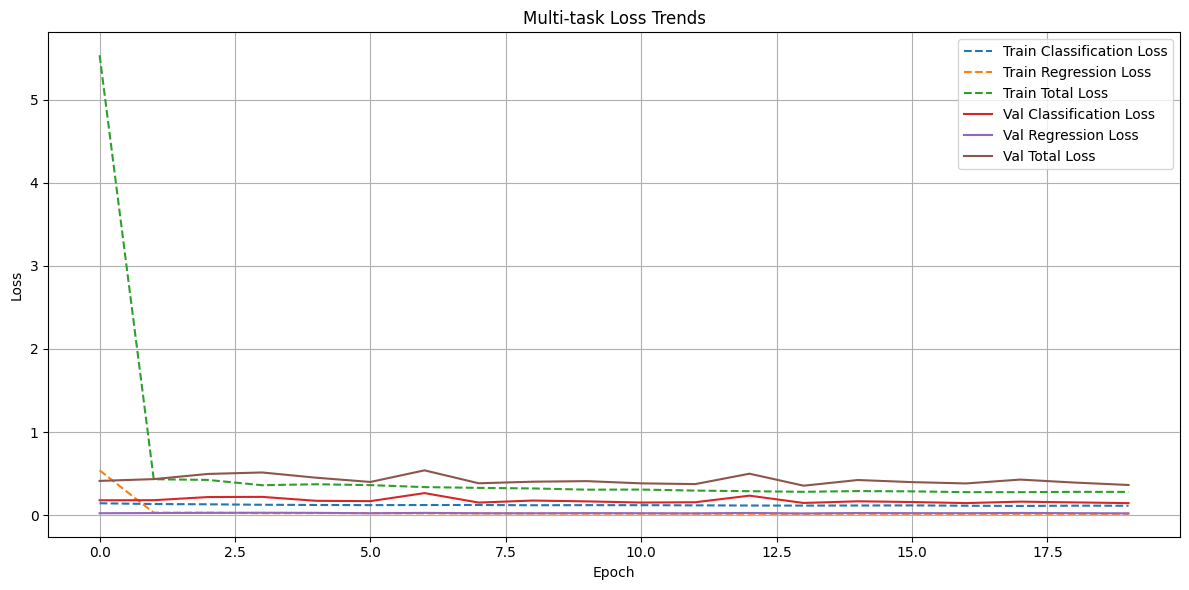

In [24]:
import json
import matplotlib.pyplot as plt

# JSON 불러오기
load_path = '/content/drive/MyDrive/cv_project/01unimodal/loss_history_multitask_수정_2.5e-3.json'

with open(load_path, 'r') as f:
    loss_history = json.load(f)

# 리스트로 추출
train_cls_losses = loss_history['train_cls_loss']
train_reg_losses = loss_history['train_reg_loss']
train_total_losses = loss_history['train_total_loss']
val_cls_losses = loss_history['val_cls_loss']
val_reg_losses = loss_history['val_reg_loss']
val_total_losses = loss_history['val_total_loss']

# 그래프 시각화
plt.figure(figsize=(12, 6))
plt.plot(train_cls_losses, label='Train Classification Loss', linestyle='--')
plt.plot(train_reg_losses, label='Train Regression Loss', linestyle='--')
plt.plot(train_total_losses, label='Train Total Loss', linestyle='--')

plt.plot(val_cls_losses, label='Val Classification Loss')
plt.plot(val_reg_losses, label='Val Regression Loss')
plt.plot(val_total_losses, label='Val Total Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Multi-task Loss Trends')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### [11] 예측 수행

In [25]:
from tqdm import tqdm
import json
import torch

# 모델 로드
model = SiameseSeResNeXtdropoutMultiTask().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/cv_project/01unimodal/best_multitask_수정_2.5e-3.pth'))
model.eval()

# 예측 수행
results = []

with torch.no_grad():
    for left, right, labels, thicknesses in tqdm(test_loader, desc="Predicting"):
        left, right = left.to(device), right.to(device)

        # 분류 + 회귀 예측
        outputs_cls, outputs_reg = model(left, right)
        probs = torch.softmax(outputs_cls, dim=1)
        preds = torch.argmax(probs, dim=1)
        thickness_preds = outputs_reg.squeeze().cpu()

        for true, pred, prob, true_thick, pred_thick in zip(
            labels.cpu(), preds.cpu(), probs[:, 1].cpu(), thicknesses.cpu(), thickness_preds):

            results.append({
                "true_label": int(true.item()),
                "pred_label": int(pred.item()),
                "prob_thickened": float(prob.item()),  # thickened 클래스 확률
                "true_thickness": float(true_thick.item()),
                "pred_thickness": float(pred_thick.item())
            })

# 결과 저장
output_path = "/content/drive/MyDrive/cv_project/01unimodal/predict_result_multitask_수정_2.5e-3.json"
with open(output_path, "w") as f:
    json.dump(results, f, indent=2)

print(f"예측 결과 저장 완료: {output_path}")


Predicting: 100%|██████████| 7/7 [01:00<00:00,  8.61s/it]

예측 결과 저장 완료: /content/drive/MyDrive/cv_project/01unimodal/predict_result_multitask_수정_2.5e-3.json


[Classification Evaluation]
정확도 (Accuracy): 0.8100
AUC-ROC: 0.8556

분류 리포트:
              precision    recall  f1-score   support

      Normal       0.92      0.68      0.78        50
   Thickened       0.75      0.94      0.83        50

    accuracy                           0.81       100
   macro avg       0.83      0.81      0.81       100
weighted avg       0.83      0.81      0.81       100

Confusion Matrix:
[[34 16]
 [ 3 47]]


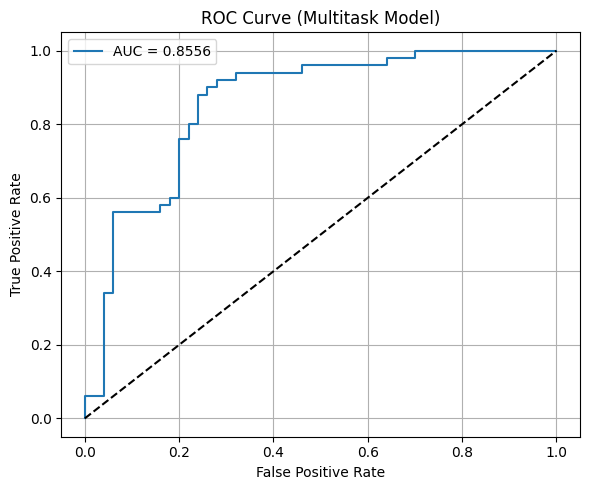


[Regression Evaluation]
RMSE: 0.1480
MAE:  0.1133
R²:   0.4046


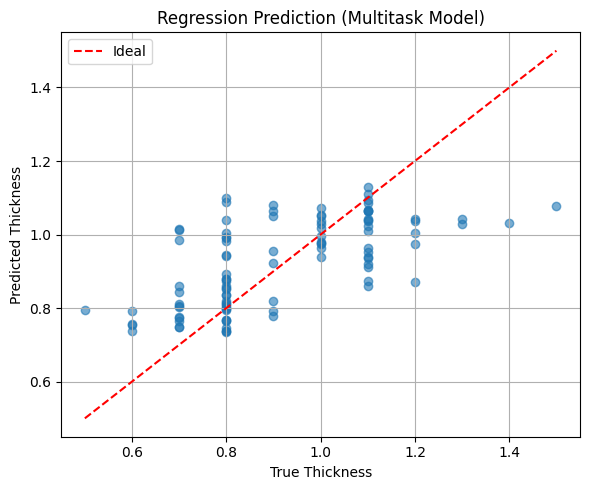

In [26]:
import json
import numpy as np
from sklearn.metrics import (
    roc_curve, roc_auc_score, classification_report, confusion_matrix,
    mean_squared_error, mean_absolute_error, r2_score
)
import matplotlib.pyplot as plt

# 예측 결과 불러오기
with open("/content/drive/MyDrive/cv_project/01unimodal/predict_result_multitask_수정_2.5e-3.json", "r") as f:
    results = json.load(f)

# 분류 관련 데이터
y_true = [r["true_label"] for r in results]
y_pred = [r["pred_label"] for r in results]
y_prob = [r["prob_thickened"] for r in results]

# 회귀 관련 데이터
y_true_reg = [r["true_thickness"] for r in results]
y_pred_reg = [r["pred_thickness"] for r in results]

# 역정규화 추가
min_val = 0.5
max_val = 1.7
y_true_reg = [t * (max_val - min_val) + min_val for t in y_true_reg]
y_pred_reg = [t * (max_val - min_val) + min_val for t in y_pred_reg]

# === 분류 평가 === #
fpr, tpr, _ = roc_curve(y_true, y_prob)
auc_score = roc_auc_score(y_true, y_prob)
accuracy = np.mean(np.array(y_true) == np.array(y_pred))

print("[Classification Evaluation]")
print(f"정확도 (Accuracy): {accuracy:.4f}")
print(f"AUC-ROC: {auc_score:.4f}")
print("\n분류 리포트:")
print(classification_report(y_true, y_pred, target_names=["Normal", "Thickened"]))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# === ROC Curve === #
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Multitask Model)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === 회귀 평가 === #
mse = mean_squared_error(y_true_reg, y_pred_reg)
rmse = np.sqrt(mean_squared_error(y_true_reg, y_pred_reg))
mae = mean_absolute_error(y_true_reg, y_pred_reg)
r2 = r2_score(y_true_reg, y_pred_reg)

print("\n[Regression Evaluation]")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")

# === 회귀 산점도 === #
plt.figure(figsize=(6, 5))
plt.scatter(y_true_reg, y_pred_reg, alpha=0.6)
plt.plot([min(y_true_reg), max(y_true_reg)], [min(y_true_reg), max(y_true_reg)], 'r--', label="Ideal")
plt.xlabel("True Thickness")
plt.ylabel("Predicted Thickness")
plt.title("Regression Prediction (Multitask Model)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()